# Adaptive Retrieval-Augmented Generation (RAG) System

This notebook implements an Adaptive Retrieval-Augmented Generation (RAG) system that adapts its retrieval strategy based on the type of user query. By leveraging Language Models (LLMs) and various retrieval strategies, the system provides more accurate, relevant, and context-aware responses. Hopefully!


## Objectives

- **Query Classification:** Classify user queries into categories like Factual, Analytical, Opinion, or Contextual.
- **Adaptive Retrieval Strategies:** Implement tailored strategies to retrieve relevant document chunks based on the query type.
- **Response Generation:** Use LLMs to generate coherent and contextually appropriate responses.
- **Visualization:** Visualize embeddings to understand the relationships between different document chunks.


## Step 1: Set Up the Environment

In [18]:
# Import necessary libraries
import os
import fitz  # PyMuPDF for PDF processing
from openai import OpenAI
import faiss  # FAISS for efficient similarity search
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from dotenv import load_dotenv

load_dotenv()

# Set the OpenAI API key environment variable 
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY', 'your_openai_api_key_here')

# Set OpenAI API key for the current session
openai.api_key = os.getenv('OPENAI_API_KEY')


## Helper Functions
define several helper functions that are essential for processing documents, generating embeddings, and visualizing the results. These functions will be used throughout the notebook to streamline our workflow.


In [19]:
# Helper functions

def load_pdf(path):
    """Load the text from a PDF file."""
    doc = fitz.open(path)
    content = ""
    for page_num in range(len(doc)):
        page = doc[page_num]
        content += page.get_text()
    return content

def split_document(text, chunk_size=500):
    """Split the document into smaller chunks."""
    sentences = text.split('.')
    chunks = [' '.join(sentences[i:i+chunk_size]) for i in range(0, len(sentences), chunk_size)]
    return chunks

def get_local_embeddings(texts):
    """Generate text embeddings using a local model."""
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(texts)
    return embeddings

def visualize_embeddings(embeddings, labels=None, method='pca'):
    """Visualize embeddings using PCA or t-SNE."""
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'.")

    reduced_embeddings = reducer.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='blue', marker='o')

    if labels:
        for i, label in enumerate(labels):
            plt.annotate(f"Chunk {i+1}", (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

    plt.title(f'Embeddings Visualization using {method.upper()}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()



In [20]:
# Load the PDF content
pdf_content = load_pdf("Muthiru_Factors Influencing Male Involvement In Young Children Feeding Practices,  A Case Of Dagoretti Informal Settlements..pdf")


In [21]:
# Split the document into smaller chunks
documents = split_document(pdf_content, chunk_size=500)  # Adjust chunk size as needed


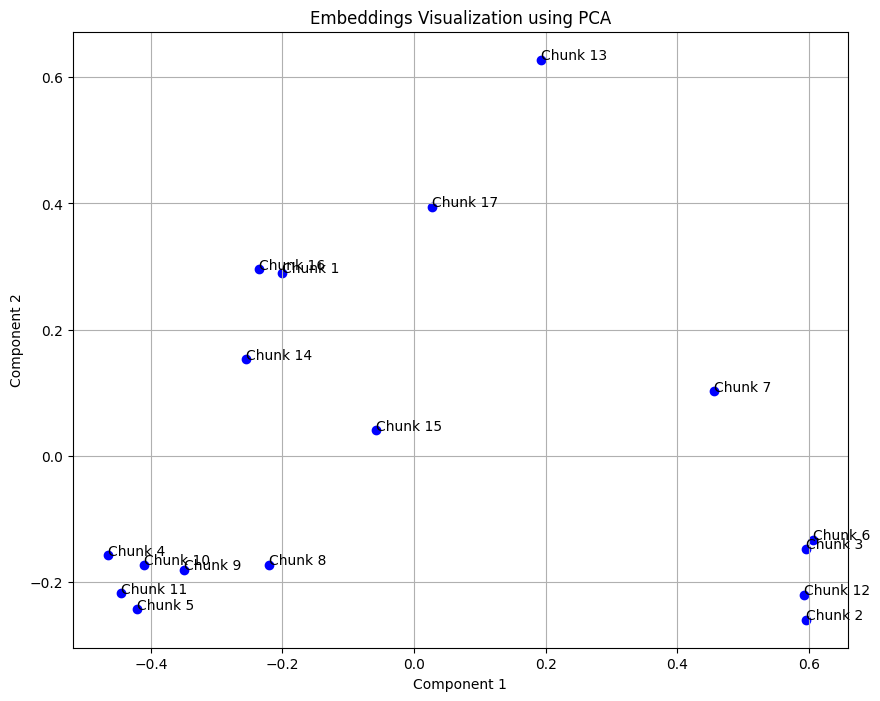

In [22]:
# Generate embeddings using sentence-transformers
embeddings = get_local_embeddings(documents)

# Visualize the embeddings
visualize_embeddings(embeddings, labels=documents, method='pca')

If some points are close to each other, it suggests that those chunks have similar embeddings, indicating that the content in those chunks is more related.
Points that are further apart likely represent chunks with less similar content.

## 3. Vector Search Using FAISS

In this section, we implement vector search using FAISS (Facebook AI Similarity Search), a library that efficiently performs similarity search on dense vectors. This is a crucial step in retrieving relevant document chunks based on the query embeddings generated earlier.


In [23]:
def create_faiss_index(embeddings):
    """Create a FAISS index for the given embeddings."""
    dim = embeddings.shape[1]
    index = faiss.IndexFlatL2(dim)
    index.add(embeddings)
    return index

def search_faiss_index(index, query_embedding, k=4):
    """Search the FAISS index for the top-k similar embeddings."""
    D, I = index.search(np.array([query_embedding]), k)
    return I

# Create a FAISS index using the local embeddings
faiss_index = create_faiss_index(embeddings)



1. **Creating the FAISS Index:**
   - The function `create_faiss_index(embeddings)` initializes a FAISS index with the given embeddings. This index uses the L2 (Euclidean) distance to measure similarity between vectors.
   - **Output:** The `faiss_index` now contains the embeddings from our document chunks, ready for fast similarity searches.

2. **Searching the FAISS Index:**
   - The function `search_faiss_index(index, query_embedding, k=4)` performs a search on the FAISS index using a query embedding. It returns the indices (`I`) of the top-k most similar document chunks.
   - **Output:** The indices `I` correspond to the most relevant chunks in our document, based on their similarity to the query. These indices can be used to retrieve and analyze the corresponding text chunks.


In [24]:
# Example query to search
query_text = "Influence of male involvement in child feeding practices"
query_embedding = get_local_embeddings([query_text])[0]

# Search the index
results = search_faiss_index(faiss_index, query_embedding, k=4)
print("Top 4 similar document chunks based on the query:")
for i in results[0]:
    print(f"Chunk {i+1}: {documents[i][:100]}...")  # Print the first 100 characters of each chunk

Top 4 similar document chunks based on the query:
Chunk 4:                                                                                          7 
CHAPTER ...
Chunk 5:                             12 
2 7 Strategies to increase male involvement in child feeding practic...
Chunk 11:                  46 
4 8 3 Ways to engage men in child feeding practices                            ...
Chunk 10:                                                                    39 
4 7 3 Support from different ...


In this example, we performed a vector search using a query related to "Influence of male involvement in child feeding practices." The FAISS index was used to find the top 4 most similar document chunks based on the query embedding.

#### Output:
- **Top 4 similar document chunks:**
  - The search returned the indices of the top 4 document chunks that are most similar to the query.
  - For each chunk, the output displays the first 100 characters to provide a glimpse of the content.

#### Detailed Explanation:
- **Chunk 4:** This chunk likely contains introductory or background information related to the topic.
- **Chunk 5:** This chunk appears to discuss strategies for increasing male involvement in child feeding practices.
- **Chunk 11:** This chunk seems to focus on ways to engage men in child feeding practices.
- **Chunk 10:** This chunk might involve support mechanisms or external influences on male involvement in child feeding.

These results indicate that the FAISS index effectively retrieved the most relevant chunks of text related to the query, providing a quick overview of the content most closely associated with the topic.


## 4. Query Classification Using OpenAI's GPT-4o mini
I'll use OpenAI's GPT-4o mini model to classify queries. Since the focus is on the classification, the function will take a query and categorize it as either Factual, Analytical, Opinion, or Contextual.

In [25]:
# Initialize the OpenAI client with the API key
client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)

def classify_query(query):
    """Classify the query into one of the predefined categories."""
    prompt = f"Classify the following query into one of these categories: Factual, Analytical, Opinion, or Contextual.\nQuery: {query}\nCategory:"
    
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="gpt-4o-mini",
        max_tokens=60,
        temperature=0
    )
    
    # Extract the category from the response
    category = chat_completion.choices[0].message.content.strip()
    return category

# Example query classification
query_type = classify_query("How does male involvement influence child feeding practices?")
print(f"Query classified as: {query_type}")


Query classified as: Analytical


## 5. Adaptive Retrieval Strategies
In this section, we define multiple retrieval strategies that are tailored to different types of queries. Each strategy retrieves relevant document chunks based on the nature of the query, ensuring that the responses generated by the system are accurate and contextually appropriate.

### Factual Retrieval Strategy
The **Factual Retrieval Strategy** is designed to handle queries that seek specific, verifiable information. It retrieves the top-k document chunks that are most similar to the query embedding.

### Analytical Retrieval Strategy
The **Analytical Retrieval Strategy** is suited for queries that require comprehensive analysis or exploration of a topic. It retrieves a broader set of document chunks to cover different aspects of the query.

### Opinion Retrieval Strategy
The **Opinion Retrieval Strategy** is used for queries that seek diverse viewpoints or opinions. This strategy retrieves document chunks that reflect various perspectives on the topic in question.

### Contextual Retrieval Strategy
The **Contextual Retrieval Strategy** incorporates user-specific context into the query to retrieve the most relevant document chunks. This is particularly useful for queries that depend heavily on the user's context or background.


In [41]:
class FactualRetrievalStrategy:
    def __init__(self, embeddings, index, documents):
        self.embeddings = embeddings
        self.index = index
        self.documents = documents

    def retrieve(self, query, k=4):
        """Retrieve documents using the factual strategy."""
        query_embedding = get_local_embeddings([query])[0]
        results = search_faiss_index(self.index, query_embedding, k)
        return [self.documents[i] for i in results[0]]

class AnalyticalRetrievalStrategy:
    def __init__(self, embeddings, index, documents):
        self.embeddings = embeddings
        self.index = index
        self.documents = documents

    def retrieve(self, query, k=8):
        """Retrieve documents using the analytical strategy."""
        query_embedding = get_local_embeddings([query])[0]
        results = search_faiss_index(self.index, query_embedding, k)
        return [self.documents[i] for i in results[0]]

class OpinionRetrievalStrategy:
    def __init__(self, embeddings, index, documents):
        self.embeddings = embeddings
        self.index = index
        self.documents = documents

    def retrieve(self, query, k=4):
        """Retrieve documents using the opinion strategy."""
        query_embedding = get_local_embeddings([query])[0]
        results = search_faiss_index(self.index, query_embedding, k)
        return [self.documents[i] for i in results[0]]

class ContextualRetrievalStrategy:
    def __init__(self, embeddings, index, documents):
        self.embeddings = embeddings
        self.index = index
        self.documents = documents

    def retrieve(self, query, user_context, k=4):
        """Retrieve documents using the contextual strategy."""
        context_query = f"{user_context}: {query}"
        query_embedding = get_local_embeddings([context_query])[0]
        results = search_faiss_index(self.index, query_embedding, k)
        return [self.documents[i] for i in results[0]]


## Step 6: Implement Response Generation

In this step, we implement a function to generate responses based on the retrieved document chunks (context) and the user's question. The function leverages OpenAI's GPT-4o-mini model to create coherent and contextually relevant responses.

The `generate_response` function takes the following inputs:

- **context**: The relevant document chunks retrieved by the selected retrieval strategy.
- **question**: The user’s query.

It combines these inputs into a prompt that is sent to the GPT-4o-mini model to generate a response.

In [35]:
def generate_response(context, question):
    """Generate a response based on the provided context and question."""
    prompt = f"Use the following context to answer the question:\n\n{context}\n\nQuestion: {question}\nAnswer:"
    
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="gpt-4o-mini",
        max_tokens=500,
        temperature=0
    )
    
    # Extract the response content
    response = chat_completion.choices[0].message.content.strip()
    return response


### Impact of Model and Parameters on Output

- **Model Choice:** Using GPT-4o-mini ensures that the responses are both relevant and resource-efficient. It strikes a balance between generating sophisticated answers and maintaining performance, which is critical for applications that require quick response times or operate on limited hardware.

- **Max Tokens:** Setting `max_tokens=500` provides a safeguard against overly verbose responses, ensuring the output is informative but concise. Increasing this value could yield more detailed responses, while decreasing it might lead to more succinct answers.

- **Temperature:** A low temperature (0 in this case) ensures the model's responses are consistent and predictable, which is particularly important for generating accurate and reliable answers in an information retrieval context. Higher temperatures could be used if more creative or varied responses are desired, though this could come at the cost of precision.


## 7. Final Integration: Adaptive RAG System
Now, we’ll put everything together into an Adaptive RAG system that uses the query classification to determine the appropriate retrieval strategy and then generates a response based on the retrieved document chunks.

In [36]:
class AdaptiveRAG:
    def __init__(self, documents, embeddings, index):
        self.documents = documents
        self.embeddings = embeddings
        self.index = index
        self.strategies = {
            "Factual": FactualRetrievalStrategy(embeddings, index, documents),
            "Analytical": AnalyticalRetrievalStrategy(embeddings, index, documents),
            "Opinion": OpinionRetrievalStrategy(embeddings, index, documents),
            "Contextual": ContextualRetrievalStrategy(embeddings, index, documents)
        }

    def answer(self, query, user_context=None):
        """Answer the query using the appropriate retrieval strategy."""
        category = classify_query(query)
        strategy = self.strategies.get(category, self.strategies["Factual"])

        if category == "Contextual" and user_context:
            retrieved_docs = strategy.retrieve(query, user_context)
        else:
            retrieved_docs = strategy.retrieve(query)

        # Combine the retrieved document chunks into a single context
        context = "\n".join(retrieved_docs)
        return generate_response(context, query)




In [40]:
# Example usage
rag_system = AdaptiveRAG(documents, embeddings, faiss_index)
response = rag_system.answer("What are the key themes appearing in this study?", user_context="Urban settings in Nairobi")
print(f"Response: {response}")

Response: The key themes appearing in the study "Factors Influencing Male Involvement in Young Children Feeding Practices: A Case of Dagoretti Informal Settlements" include:

1. **Male Engagement in Child Feeding Practices**: The study explores the extent and nature of male involvement in the feeding practices of young children, highlighting the importance of their participation for better health outcomes.

2. **Knowledge and Awareness**: It examines the knowledge of respondents regarding child feeding, including understanding signs of malnutrition and the nutritional needs of children.

3. **Attitudes and Perceptions**: The study investigates the attitudes of men towards their role in child feeding and how these attitudes influence their actual involvement.

4. **Barriers to Involvement**: It identifies various barriers that hinder male participation in child feeding practices, such as work commitments and household conflicts.

5. **Demographic Factors**: The research analyzes how dem

## Testing the System

In [38]:
# Example queries to test the system
queries = [
    "What are the key factors influencing male involvement in child feeding practices?",
    "Analyze the impact of socio-economic status on male involvement in child feeding.",
    "What are different opinions about male involvement in child feeding?",
    "How does male involvement in child feeding differ in rural versus urban settings?"
]

# Context for contextual queries
user_context = "Urban settings in Nairobi"

# Initialize the Adaptive RAG system 
rag_system = AdaptiveRAG(documents, embeddings, faiss_index)

# Test the system with each query
for query in queries:
    print(f"Query: {query}")
    response = rag_system.answer(query, user_context=user_context)
    print(f"Response: {response}")
    print("\n" + "-"*80 + "\n")


Query: What are the key factors influencing male involvement in child feeding practices?
Response: The key factors influencing male involvement in child feeding practices, as identified in the study, include:

1. **Knowledge and Attitudes**: Many men have a basic understanding of appropriate foods for children and the importance of nutrition. However, their knowledge is often limited, and they may not fully grasp the significance of certain foods or feeding practices. Attitudes towards child feeding can also be influenced by cultural norms that assign feeding responsibilities primarily to women.

2. **Cultural and Social Norms**: Traditional gender roles often dictate that child feeding is a woman's responsibility, leading to limited male participation. Men may avoid activities perceived as "women's work," which can hinder their involvement in child feeding practices.

3. **Decision-Making Dynamics**: Men typically hold significant decision-making power within households, which can imp